<h2>Enable the ipyparallel engine for parallel computing</h2>
<h4>(Ignore this step if you want to use single core mode)</h4>

In [2]:
import ipyparallel as ipp
import subprocess
import time
subprocess.Popen(["ipcluster", "start"])
for i in range(10):
    print("Wait for engine starting: %.2d " %(10-i-1) ,'s',end='\r')
    if i==9:
        print("\nEngine is starting now")
    time.sleep(1)
c=ipp.Client()
n_thread=8
Task=c[:n_thread]

Wait for engine starting: 00  s
Engine is starting now


<h3>Class and function for SGSIM</h3>

In [16]:
%%px --local 
# Push these class and function to all engines.

import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import numpy as np
import time

class UC_SGSIM():
    
    def __init__(self,start,end,grid_size,model,hs,bw,nR,a,C0,randomseed):
        self.start=start
        self.end=end
        self.grid_size=grid_size
        self.model=model
        self.hs=hs
        self.bw=bw
        self.nR=nR
        self.a=a
        self.C0=C0
        self.randomseed=randomseed
        self.RandomField=np.empty([self.end-self.start+1,self.nR])
    

    def Variogram(self,L, hs, bw):

        dist=squareform(pdist(L[:,:1]))

        variogram=[]

        for h in hs:

            Z=[]

            for i in range(len(dist[:,0])):

                for j in range(i+1,len(dist[:,0])):

                    if( dist[i,j] >= h-bw )and( dist[i,j] <= h+bw ):

                        Z.append(np.power(L[i,1]-L[j,1],2))

            if np.sum(Z)>=1e-6:

                variogram.append(np.sum(Z)/(2*len(Z)))



        return np.array(variogram)



    def Gaussian(h,a,C0):
        
        
        x=C0*(1-np.exp(-3*h**2/a**2))
        
        return x


    def Spherical( h, a, C0 ):

        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0

    def Cov_model( Y, model,a,C0=1 ):
        
        Z=np.empty(len(Y))
        
        for i in range(len(Y)):

            Z[i]=C0-model(Y[i],a,C0)

        return Z

    def Var_model(self, Y, model,a,C0=1 ):

        Z=np.empty(len(Y))

        for i in range(len(Y)):

            Z[i]=model(Y[i],a,C0)

        return Z
    
    def SimpleKrige(self, Y, model, hs, bw, u, N ,randomseed,a,C0=1):
        
        
        if N==0:
            np.random.seed(randomseed)
            temp=np.random.normal(0,1,1)
            return temp
        
        dist = abs( Y[:,0]-u )
        dist = dist.reshape(len(dist),1)

        close=0
        for i in range(len(dist)):
            if dist[i]<=a:
                close=close+1

        if close==0:
            np.random.seed(randomseed)
            temp=np.random.normal(0,1,1)
            return temp
        
        Y=np.hstack([Y,dist])
        
        Y=sorted(Y,key=lambda x:x[2])[:N]
        
        Y=np.array(Y)
        
        #meanvalue = np.mean( Y[:,1] )
        meanvalue = 0
        
        C_dist = UC_SGSIM.Cov_model(Y[:,2],model,a,C0)

        C_dist = np.matrix( C_dist ).T

        C_data = squareform( pdist( Y[:,:1] ) )

        C_data = UC_SGSIM.Cov_model(C_data.flatten(),model,a)
        
        C_data = np.array( C_data ).reshape(N,N)
        
        weights = np.linalg.inv(C_data) * C_dist 

        residuals = (Y[:,1] - meanvalue)


        estimation=np.dot(weights.T,residuals)+meanvalue
        #estimation=np.dot(weights.T,Y[:,1])+(1-np.sum(weights))*meanvalue


        v=np.dot(weights.T,C_dist)

        var=float(1-v)
        
        if var<0:
            var=0
        
        cstd=np.sqrt(var)

        np.random.seed(randomseed)
        fix=np.random.normal(0,cstd,1)
        

        Simulated=float(estimation+fix)

        return Simulated

    def Shi_Ming(A,B):

        A=A.tolist()
        B=B.tolist()

        for i in range(len(A)):
            if np.float64(A[i][0])>np.float64(B[0]):
                A.insert(i,B)
                return A
        A.append(B)
        return np.array(A)
    
    
    def Simulation(self):
        
        
        initial_seed=self.randomseed
        
        counts=0
        
        #RandomField=np.empty([self.end-self.start+1,self.nR])

               
        start_time=time.time()
        
        #while counts<self.nR:
        while counts<nR:
            
            check=np.random.randint(0,2,1)
            check=0
            u=np.linspace(self.start,self.end,self.end-self.start+1)
            
            if check==0:
                first=np.random.randint(0,151,1)
                k=np.array([first]).reshape(1,1)
                t=np.random.normal(0,1,1).reshape(1,1)
                Z = np.zeros(self.end-self.start+1)
                Z[first]=t
                u=np.delete(u,[first])
                neigh=0

            L=np.hstack([k,t])


            np.random.seed(self.randomseed)
            randompath=np.random.choice(u,len(u),replace=False)
            
            
            for i in range(len(u)):

                Z[int(randompath[i])]=self.SimpleKrige(L,self.model,self.hs,self.bw,randompath[i],neigh,self.randomseed,self.a,self.C0)
               
                temp=np.hstack([randompath[i],Z[int(randompath[i])]])

                L=np.vstack([L,temp])


                #L=np.reshape(Shi_Ming(L,temp),(2+1+i,2))
                
                if neigh<6:
                    neigh=neigh+1
                self.randomseed=self.randomseed+1
                
 
                
            Z_Gap=abs(Z.max()-Z.min())
                 

            if 2<Z_Gap<=6.5:
                self.RandomField[:,counts]=Z
                counts=counts+1
                print('Progress = %.2f' % (counts/self.nR*100)+'%', end='\r')

            self.randomseed=self.randomseed+1
            
        print('Progress = %.2f' % 100+'%\n', end='\r')
        
        end_time=time.time()
        
        print('Time = %f'%(end_time-start_time),'s\n')
        print("Last RandomSeed = %d" %(self.randomseed),'\n')
        print("RandomSeed passed = %d" %(self.randomseed-initial_seed),'\n')
        print("Theroritical Randomseed = %d" %(initial_seed+(self.end-self.start)*self.nR))
        return self.RandomField
    
    def Simulation_P(start,end,grid_size,model,hs,bw,nR,a,C0,randomseed):
        
        import numpy as np
        RandomField=np.empty([int(end-start+1),nR])
        
        counts=0
        
        while counts<nR:
            
            check=np.random.randint(0,2,1)
            check=0
            u=np.linspace(start,end,end-start+1)
            
            if check==0:
                first=np.random.randint(0,151,1)
                k=np.array([first]).reshape(1,1)
                t=np.random.normal(0,1,1).reshape(1,1)
                Z = np.zeros(end-start+1)
                Z[first]=t
                u=np.delete(u,[first])
                neigh=0
            
            L=np.hstack([k,t])


            np.random.seed(randomseed)
            randompath=np.random.choice(u,len(u),replace=False)
            
            
            for i in range(len(u)):

                Z[int(randompath[i])]=UC_SGSIM.SimpleKrige(0,L,model,hs,bw,randompath[i],neigh,randomseed,a,C0)
                
                temp=np.hstack([randompath[i],Z[int(randompath[i])]])

                L=np.vstack([L,temp])
                
                if neigh<6:
                    neigh=neigh+1
                    
                randomseed=randomseed+1
                
            Z_Gap=abs(Z.max()-Z.min())
                 

            if 2<Z_Gap<=6.5:
                RandomField[:,counts]=Z
                counts=counts+1
 
            randomseed=randomseed+1

        return RandomField
        
    def Simulation_Parallel(self,n_thread):
        
        c=ipp.Client()
        print("CPU ID:",c.ids)
        Task=c[:n_thread]

        # initialize the map list for parallel computation

        start=[];end=[];grid_size=[];model=[];hs=[];bw=[];nR=[];a=[];C0=[];randomseed=[];
        for i in range(n_thread):
            s=self.randomseed+int(i)*(self.nR/n_thread+300)*(self.end-self.start)
            start.append(self.start)
            end.append(self.end)
            grid_size.append(self.grid_size)
            model.append(self.model)
            hs.append(self.hs)
            bw.append(self.bw)
            nR.append(int(self.nR/n_thread))
            a.append(self.a)
            C0.append(self.C0)
            randomseed.append(int(s))        

        Z=Task.map_sync(UC_SGSIM.Simulation_P,start,end,grid_size,model,hs,bw,nR,a,C0,randomseed)
        print("Zshape=",np.shape(Z))
        
        for i in range(n_thread):
            for j in range(int(self.nR/n_thread)):
                self.RandomField[:,(j+int(i*self.nR/n_thread))]=Z[i][:,j]
                
        return self.RandomField
        
    
    def Plot(self,n,mean=0,std=1):
        
        if self.model==UC_SGSIM.Gaussian:
            
            Str_model="Gaussian"
            
        elif self.model==UC_SGSIM.Spherical:
            
            Str_model="Spherical"
        
        if n=="ALL":
            
            for i in range(self.nR):
                plt.figure(77879,figsize=(7,4))
                plt.plot(self.RandomField[:,i]*std+mean)
                plt.title("Realizations: "+Str_model,fontsize=20)
                plt.xlabel("Distance(m)",fontsize=20)
                plt.axhline(y=mean, color='r', linestyle='--',zorder=1)
                plt.ylabel("Thermal Conductivity",fontsize=20)
            
        else:
            for item in n:
                plt.figure(77879,figsize=(7,4))
                plt.plot(self.RandomField[:,item]*std+mean)
                plt.title("Realizations: "+Str_model,fontsize=20)
                plt.xlabel("Distance(m)",fontsize=20)
                plt.axhline(y=mean, color='r', linestyle='--',zorder=1)
                plt.ylabel("Thermal Conductivity",fontsize=20)
            
        plt.show()
        
        
    def Statistic_Plot(self,mean=0,std=1):

        Zmean=np.zeros(len(self.RandomField[:,0]))


        for i in range(len(self.RandomField[:,0])):

            Zmean[i]=np.mean(self.RandomField[i,:]+mean)
        
        plt.figure(5212,figsize=(7,4))
        plt.plot(Zmean,'-s',color='k',markeredgecolor='k',markerfacecolor='y')
        plt.xlabel("Distance(m)",fontsize=20)
        plt.ylabel("Mean",fontsize=20)
        plt.axhline(y=mean, color='r', linestyle='--',zorder=1)
        plt.xticks(fontsize=17),plt.yticks(fontsize=17)
        plt.show()
        Zvar=np.zeros(len(self.RandomField[:,0]))

        for i in range(len(self.RandomField[:,0])):

            Zvar[i]=np.var(self.RandomField[i,:]*std)
            
        plt.figure(52712,figsize=(7,4))
        plt.plot(Zvar,'-o',color='k',markeredgecolor='k',markerfacecolor='r')
        #plt.title("Variance",fontsize=24)
        plt.xlabel("Distance(m)",fontsize=20)
        plt.ylabel("Variance",fontsize=20)
        plt.axhline(y=std**2, color='b', linestyle='--',zorder=1)
        plt.xticks(fontsize=17),plt.yticks(fontsize=17)
        plt.show()
    
    def Variogram_Plot(self):
        
        start_time=time.time()
        
        if self.model==UC_SGSIM.Gaussian:
            
            Str_model="Gaussian"
            
        elif self.model==UC_SGSIM.Spherical:
            
            Str_model="Spherical"
        
        model_len=self.end-self.start+1
        
        Vario=np.zeros([len(self.hs),self.nR])
        
        x=np.linspace(self.start,self.end,model_len).reshape(model_len,1)
        
        for i in range(self.nR):
            L=np.hstack([x,self.RandomField[:,i].reshape(model_len,1)])
            
            Vario[:,i]=self.Variogram(L,self.hs,self.bw)
            plt.figure(123456,figsize=(10,6))
            plt.plot(Vario[:,i],alpha=0.1)
            plt.title("Model: "+Str_model,fontsize=20)
            plt.xlabel("Lag(m)",fontsize=20)
            plt.ylabel("Variogram",fontsize=20)
            plt.xticks(fontsize=17),plt.yticks(fontsize=17)
            print('Progress = %.2f' % (i/self.nR*100)+'%', end='\r')
            
        plt.plot(self.Var_model(self.hs,self.model,self.a),'o',markeredgecolor='k',markerfacecolor='w')
        
        Vario_mean=np.zeros(len(self.hs))
        for i in range(len(self.hs)):
            
            Vario_mean[i]=np.mean(Vario[i,:])
            
        plt.plot(Vario_mean,'--',color='blue')
        
        print('Progress = %.2f' % 100+'%\n', end='\r')
        
        end_time=time.time()
        
        print('Time = ', end_time-start_time,'s')
        
    def Variogram_Plot_P(self,n_thread):
        
        start_time=time.time()
        
        c=ipp.Client()
        print("CPU ID:",c.ids)
        Task=c[:n_thread]

        if self.model==UC_SGSIM.Gaussian:
            
            Str_model="Gaussian"
            
        elif self.model==UC_SGSIM.Spherical:
            
            Str_model="Spherical"
        
        model_len=self.end-self.start+1
        
        Vario=np.zeros([len(self.hs),self.nR])
        
        x=np.linspace(self.start,self.end,model_len).reshape(model_len,1)
        
        hs=[];bw=[];temp=[];L=[]
        
        for i in range(self.nR):
            temp.append(0)
            L.append(np.hstack([x,self.RandomField[:,i].reshape(model_len,1)]))
            hs.append(self.hs)
            bw.append(self.bw)
            
        Z=Task.map_sync(UC_SGSIM.Variogram,temp,L,hs,bw)
        Vario=np.array(Z).T
        print(np.shape(Vario))
      
        for i in range(self.nR):
            
            plt.figure(123456,figsize=(10,6))
            plt.plot(Vario[:,i],alpha=0.1)
            plt.title("Model: "+Str_model,fontsize=20)
            plt.xlabel("Lag(m)",fontsize=20)
            plt.ylabel("Variogram",fontsize=20)
            plt.xticks(fontsize=17),plt.yticks(fontsize=17)
            
            
        plt.plot(self.Var_model(self.hs,self.model,self.a),'o',markeredgecolor='k',markerfacecolor='w')
        
        Vario_mean=np.zeros(len(self.hs))
        
        for i in range(len(self.hs)):
            
            Vario_mean[i]=np.mean(Vario[i,:])
            
        plt.plot(Vario_mean,'--',color='blue')
        
        end_time=time.time()
        print('Time = ', end_time-start_time,'s')
    
    def Savedata(self,path):
        
        path=path+"\\"
        
        mlen=self.end-self.start+1
        
        for i in range(self.nR):
            
            if i<10:
                number='000'+str(i)
            elif 10<=i<100:
                number='00'+str(i)
            elif 100<=i<1000:
                number='0'+str(i)
            elif i>=1000:
                number=str(i)
            
            with open(path+'Realizations'+number+'.txt', 'w') as f:

                for j in range(0, mlen):

                    print('%.2d' %(j) ,'%10.6f' %(self.RandomField[j,i]), file=f)
        
                
        

<h3>Single core mode</h3>

Progress = 100.00%
Time = 0.617159 s

Last RandomSeed = 57964 

RandomSeed passed = 1510 

Theroritical Randomseed = 57954
(151, 10)


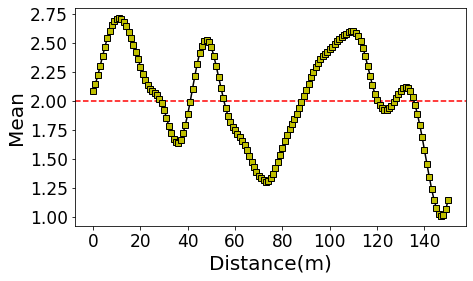

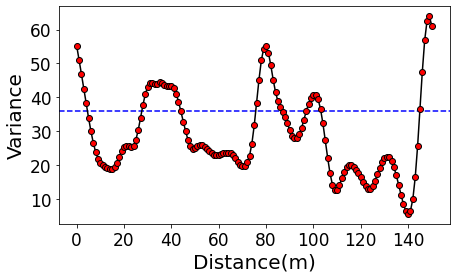

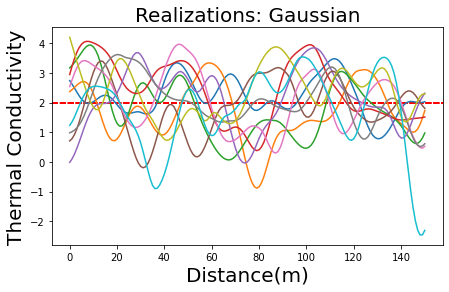

In [18]:
import time

start=0
end=150
grid_size=1
bw=1
hs=np.arange(0.,30,bw)
nR=10
a=17.32
C0=1
randomseed=56454

C1=UC_SGSIM(start,end,grid_size,UC_SGSIM.Gaussian,hs,bw,nR,a,C0,randomseed)

R=C1.Simulation()

print(np.shape(R))

C1.Statistic_Plot(mean=2,std=6)

C1.Plot('ALL',mean=2)

C1.Savedata(r"C:\Users\3002shinning\Desktop\C++\Test")

<h3>Variogram Plotting (Single Core mode)</h3>

Progress = 100.00%
Time =  25.55900001525879 s


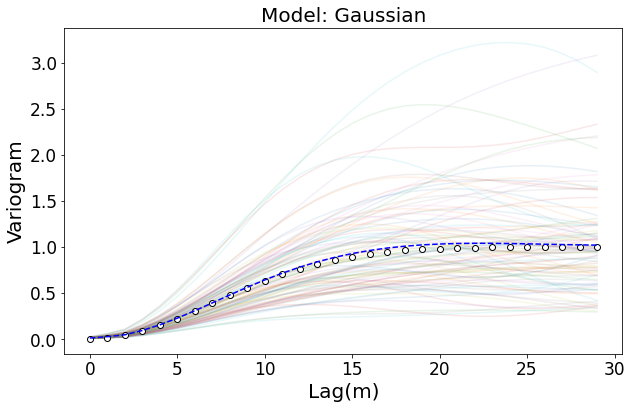

In [19]:
C1.Variogram_Plot()

<h3>Multi-Core Mode</h3>

CPU ID: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Zshape= (8, 151, 100)
Time =  6.682143449783325 s
(151, 800)


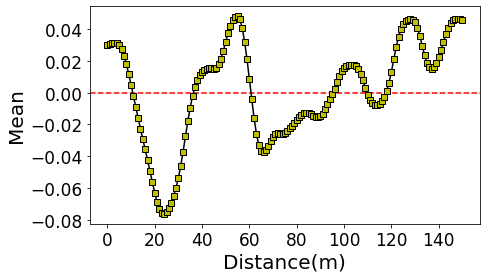

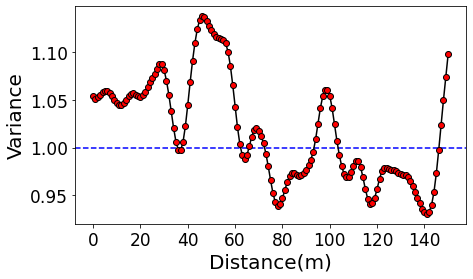

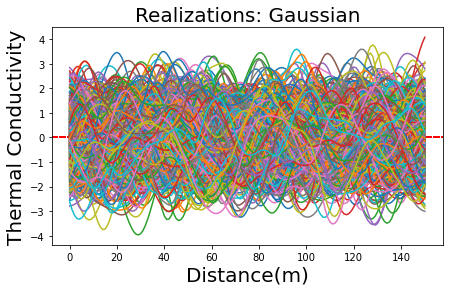

In [18]:
import time
start=0
end=150
grid_size=1
bw=1
hs=np.arange(0.,30,bw)
nR=800
a=17.32
C0=1
randomseed=5645
n_thread=8

start_time=time.time()

C2=UC_SGSIM(start,end,grid_size,UC_SGSIM.Gaussian,hs,bw,nR,a,C0,randomseed)

Z=C2.Simulation_Parallel(n_thread)

end_time=time.time()

print("Time = ",end_time-start_time,'s')

print(np.shape(Z))

C2.Statistic_Plot()

C2.Plot('ALL')


<h3> Variogram Plotting (Multi-Core mode)</h3>

CPU ID: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
(30, 800)
Time =  35.79351329803467 s


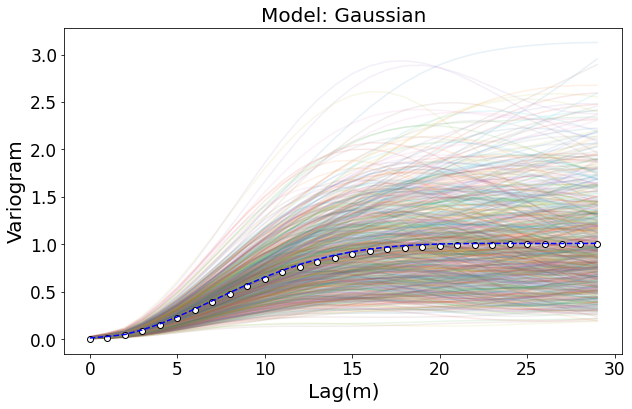

In [20]:
C2.Variogram_Plot_P(8)

<h3>Stop Engine</h3>

In [21]:
subprocess.Popen(["ipcluster", "stop"])